In [1]:
#Homework 7
#Mackenzie James
#Due: 4/3/20

#collaborated with: Jimmy Lilly, Madison Walder, Ryan Webster, and Sean Cunningham

In [20]:
# import modules
import numpy as np
import astropy.units as u
import astropy.constants as const

# import plotting modules
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# import Latex module so we can display the results with symbols
from IPython.display import Latex

# my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from GalaxyMass import ComponentMass
from OrbitCOM import VecDif

In [30]:
### Part 2: Defining All the Acceleration Terms ###


#creates a class that has a series of fucntions that will determine
#the acceleration M33 feels from M31, intergrate current position and 
#velocity forwards in time
class M33AnalyticOrbit:
    
    #initialize the class
    def __init__(self,filename):
    #inputs:
        #filename: takes the file that will will store the integrated orbit
        
        #Setting Gravitational Constant
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        #store output file name
        self.filename = filename
        
        ##relative COM position and velocity of M33 to M31 (from HW 4)
        #M33 data
        M33COM = CenterOfMass("M33_000.txt", 2)
        M33_COMP = M33COM.COM_P(0.1,4)
        M33_COMV = M33COM.COM_V(M33_COMP[0], M33_COMP[1], M33_COMP[2])
        #M31 data
        M31COM = CenterOfMass("M31_000.txt", 2)
        M31_COMP = M31COM.COM_P(0.1,2)
        M31_COMV = M31COM.COM_V(M31_COMP[0], M31_COMP[1], M31_COMP[2])
        #difference between M31 and M33, setting initial vector
        self.r0 = (M31_COMP - M33_COMP).value
        self.v0 = (M31_COMV - M33_COMV).value
        
        #scale length and masses for each component in M31
        self.rdisk = 5.0 #in kpc
        self.Mdisk = (ComponentMass("M31_000.txt",2)).value #Msun
        self.rbulge = 1 #kpc
        self.Mbulge = (ComponentMass("M31_000.txt",2)).value#Msun
        self.rhalo = 60.2 #a for M31 from HW
        self.Mhalo = (ComponentMass("M31_000.txt",2)).value
        
    
    def HernquistAccel(self,M,ra,r):
    #inputs:
        #M - total halo or bulge mass
        #ra - corresponding scale length
        #r0 - relative initial postion vector 
    #returns: 
        #the acceleration vector from a Hernquist potential
        
        #magnitude of positon vector
        rmag = np.sqrt((r[0]**2)+(r[1]**2)+(r[2]**2))
        
        #acceleration vector
        #prefactor term (all of the constants)
        prefactor = -((self.G*M)/(rmag*((ra+rmag)**2)))
        #acceleration of this factor
        #Hern = [x*prefactor for x in r]
        Hern = prefactor*r
        
        #print(Hern)
        #print(len(Hern))
        return Hern
    
    
    def MiyamotoNagaiAccel(self,M,rd,r):
    #inputs:
        #M - Disk Mass
        #rd - self.rdisk value from __init__ function
        #r0 - relative initial postion vector
    #returns:
        #the acceleration vector for disk particles using MiyamotoNagai potential
        
        
        #magnitude of positon vector
        #rmag = np.sqrt((r[0]**2)+(r[1]**2)+(r[2]**2))
        
        #variables given in assignment above equation (3)
        R = np.sqrt((r[0]**2)+(r[1]**2))
        zd = self.rdisk/5.0
        B = rd + (np.sqrt((r[2]**2)+(zd**2)))
        
        #the components for x and y are the same, so putting them in array as constant C
        C = -((self.G*M)/((R**2+B**2)**1.5))
        
        #now it will be that constant multiplied by an array with 1 for x and y
        # and adding the extra terms for z
        zterms = B/(np.sqrt(r[2]**2+zd**2))
        arrayterms = np.array([1,1,zterms])
        
        #using the prefactor method again for this acceleration term
        prefactor2 = C*arrayterms
        #print(prefactor2)
        #now calculate the components
        MiyaNag = prefactor2 * r
        #print(MiyaNag)
        #print(len(MiyaNag))
        return MiyaNag
    
    
    #function that sums all acceleration vectors from each galaxy component
    def M31Accel(self,r):
    #return:
        #The 3D vector of the total acceleration
        
        AcclHalo = self.HernquistAccel(self.Mhalo,self.rhalo,r)
        AcclBulge = self.HernquistAccel(self.Mbulge,self.rbulge,r)
        AcclDisk = self.MiyamotoNagaiAccel(self.Mdisk,self.rdisk,r)
        #print("halo = ",AcclHalo)
        #print("bulge = ", AcclBulge)
        #print("Disk = ", AcclDisk)
        Acc = AcclHalo + AcclBulge + AcclDisk
        
        #HernTerms = np.add(AcclHalo,AcclBulge) 
        #Acc = np.add(HernTerms,AcclDisk)
        #print(Acc)
        return Acc
    
### Part 3: Build an Integrator ###
    #function that is using the "Leap Frog" integration for the 
    # orbit of M33
    def LeapFrog(self,dt,r,v):
    #inputs:
        #dt - time interval for integration
        #r - starting postion vector for M33 COM position (relative to M31)
        #v - starting velocity vector for M33 (relative to M31)
    #return:
        #the new postion and velocity vectors

        #predicting position at the next halfstep
        rhalf = r + v*(dt/2)
        #print("rhalf = ",rhalf)
        
        #predict final velocity at next timestep using the acceleration at halfstep
        vnew = v + self.M31Accel(rhalf)*dt
        #print("vnew = ", vnew)
        #predict final position using average of current and final velocity
        rnew = rhalf + vnew*(dt/2)
        #print("rnew = ", rnew)
        
        return rnew, vnew
    
    #function to loop over the integrator to solve the equations of motion
    def OrbitIntegrator(self,t0,dt,tmax):
    #inputs:
        #t0 - starting time
        #dt- a time interval
        #tmax - final time
    #returns
        #future orbit of M33
        
        #initialze time t to the starting time
        t = t0
        
        #initialize an empty array from given parameters (in template)
        orbit = np.zeros((int((tmax/dt)+2),7))
        
        #initialize first row of the orbit
        orbit[0] = t0, *tuple(self.r0), *tuple(self.v0)
        
        #initialize a counter for the orbit
        i = 1
        
        #start integration
        while (t <= tmax):
            t = t + dt #advance the time by one timestep
            
            #store new time in first column of ith row
            orbit[i,0] = t
            
            #advance pos. and vel. by using LeapFrog
            #LeapFrog has two returns, so like position is LeapFrog[0] and veloctiy is LeapFrog [1]
            rnew, vnew = self.LeapFrog(dt,orbit[i-1,1:4],orbit[i-1,4:7])
            
            #store new postion vector
            orbit[i,1:4] = rnew
            #store new velocity vector
            orbit[i,4:7] = vnew
            
            #update counter i """
            i = i + 1
            
        #write data to a file
        np.savetxt(self.filename, orbit, fmt= "%11.3f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
            
            
        

In [37]:
file = "M33RelativeOrbit.txt"
orbit = M33AnalyticOrbit(file)
orbit.OrbitIntegrator(0.0,0.0005,10.0)

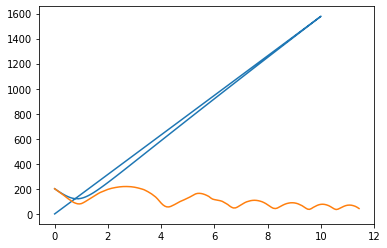

<Figure size 432x288 with 0 Axes>

In [42]:
###plotting the position and velocity for question 1 in part 5


#all data from OrbitCOM from last hw assignment, so we compare this 
#plot to that one
M31file = "Orbit_M31.txt"
M33file = "Orbit_M33.txt"
M31data = np.genfromtxt(M31file,dtype=None,names=True)
M33data = np.genfromtxt(M33file,dtype=None,names=True)

#find the difference for the velocity and positon vectors

time_sim = M33data['t']
#posdif_sim = VecDif(M33data,M31data)
#print(posdif_sim)

###Calculated difference in position and velocity from last hw's code
### M31 and M33 ###

#data for M31 position and velocity over time
M31x = np.array(M31data['x'])
M31y = np.array(M31data['y'])
M31z = np.array(M31data['z'])
M31vx = np.array(M31data['vx'])
M31vy = np.array(M31data['vy'])
M31vz = np.array(M31data['vz'])
#initializing empty 2D array for position and velocity vectors
M31pos = np.zeros([161,3])
M31vel = np.zeros([161,3])

#data for M33 position and velocity over time
M33x = np.array(M33data['x'])
M33y = np.array(M33data['y'])
M33z = np.array(M33data['z'])
M33vx = np.array(M33data['vx'])
M33vy = np.array(M33data['vy'])
M33vz = np.array(M33data['vz'])
#initializing empty 2D array for position and velocity vectors
M33pos = np.zeros([161,3])
M33vel = np.zeros([161,3])

#initalizing arrays to hold the values for the difference in position and
#the relative velocity between the M31 and M33
posdif_sim = np.zeros(161)
veldif_sim = np.zeros(161)
for i in range(161):
    #M31 x,y,z position
    M31pos[i] = [M31x[i],M31y[i],M31z[i]]
    #M33 x,y,z position
    M33pos[i] = [M33x[i],M33y[i],M33z[i]]
    #difference in position
    posdif_sim[i] = VecDif(M31pos[i],M33pos[i])

    #M31 x,y,z velocity components
    M31vel[i] = [M31vx[i],M31vy[i],M31vz[i]]
    #M33 x,y,z velocity components
    M33vel[i] = [M33vx[i],M33vy[i],M33vz[i]]
    #relative velocity
    veldif_sim[i] = VecDif(M31vel[i],M33vel[i])


#using data from analytical function above
M33AnalyticFile = "M33RelativeOrbit.txt"
M33AnalyticData = np.genfromtxt(M33AnalyticFile,dtype=None,names=True)

#time
M33_M31_time = M33AnalyticData['t']

#magnitude of difference in relative position from analysis code above
posdif_analysis = np.sqrt(M33AnalyticData['x']**2 + M33AnalyticData['y']**2 + M33AnalyticData['z']**2)

#magnitude of difference in relative velocity from analysis code above
veldif_analysis = np.sqrt(M33AnalyticData['vx']**2 + M33AnalyticData['vy']**2 + M33AnalyticData['vz']**2)


#plot the two on top of each other

#positon plot
plt.plot(M33_M31_time,posdif_analysis)
plt.plot(time_sim,posdif_sim)
plt.show()
plt.savefig("weeee.jpg")


#velocity plot
plt.plot(M33_M31_time,veldif_analysis)
plt.plot(time_sim,)